In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
!pip install -q keras numpy sklearn h5py matplotlib

In [6]:
# Import all relevant libraries
import warnings
def fxn(): 
	warnings.warn("deprecated",DeprecationWarning)

with warnings.catch_warnings( ):
    warnings.simplefilter("ignore")
    fxn( )

# Keras imports
import keras
from keras.models import Sequential
from keras.layers import Permute, Flatten, Softmax, Dense, Conv1D, Conv2D, Conv2DTranspose, AveragePooling2D, AveragePooling1D, Activation, Reshape, Dropout, BatchNormalization, MaxPooling2D, LSTM, GRU
from keras import regularizers
from keras.optimizers import Adam
from keras.utils import np_utils

# Other
import numpy as np
import h5py
import sklearn
from sklearn.model_selection import StratifiedKFold, train_test_split, StratifiedShuffleSplit
from sklearn import preprocessing
import matplotlib.pyplot as plt

# random seed for reproducability
np.random.seed(1)

In [7]:
# Load data from specific trial
def get_trial(trial_num):    
    trial = h5py.File('../data/A0' + str(trial_num) + 'T_slice.mat', 'r')
    X = np.copy(trial['image'])
    y = np.copy(trial['type'])
    y = y[0,0:X.shape[0]:1]
    y = np.asarray(y, dtype=np.int32)
    y -= 769                            # shift class labels to [0-3]
    X = np.nan_to_num(X)[:, :22, :]     # remove EOG channels
    return X, y

def get_all_trials():
    X_total = np.concatenate([get_trial(trial_num)[0] for trial_num in range(1, 9)], axis=0)
    y_total = np.concatenate([get_trial(trial_num)[1] for trial_num in range(1, 9)], axis=0)
    return X_total, y_total

def stratified_train_test_split(X, y, k, num_trials):
    ''' Returns a stratified train/test split, for k number of splits.
    Return value is in the form [(train indices, test indices), ... for k folds ]
    '''
    sss = StratifiedShuffleSplit(n_splits=k, test_size=50*num_trials)
    return sss.split(X, y)

In [8]:
num_folds = 5

# Get the data from one person
# X, y = get_trial(2)
# num_trials = 1

# Get the data from all the people
X, y = get_all_trials()
num_trials = 9

# 0 mean and unit variance
temp = np.reshape(X, (X.shape[0], -1))
X = np.reshape(preprocessing.scale(temp), X.shape)

# Generate train/test split
y_cat = keras.utils.to_categorical(y, num_classes=4)
tt_splits = stratified_train_test_split(X, y, num_folds, num_trials)

print(tt_splits)

# The data for each trial is of the shape (288, 22, 1000)
#   There are 288 samples per trial (12 of each class per "run", 4 classes, 6 "runs" 
#                                   at different time periods of the day)
#   There are 22 electrodes from the EEG (represents spatial aspect of the signals)
#   There are 1000 time units (4 seconds of data, sampled at 250Hz). The first 250 units
#                                   are when no movement occurs (but the cue is heard) and
#                                   the next 750 units are when the movement occurs
# The labels for each trial belong in one of 4 classes
#   0 - left
#   1 - right
#   2 - foot
#   3 - tongue

# Set training params for NN
batch_size = 32
val_split = 0.2
num_epochs = 5

<generator object BaseShuffleSplit.split at 0x122216d58>


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_3 (Permute)          (None, 1000, 22)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 1000, 128)         77312     
_________________________________________________________________
flatten_3 (Flatten)          (None, 128000)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 200)               25600200  
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 804       
Total params: 25,678,316
Trainable params: 25,678,316
Non-trainable params: 0
________________________________________________________________

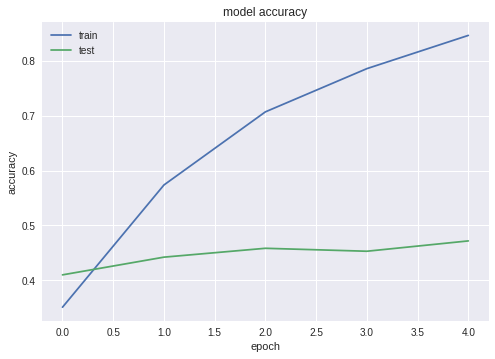

450/450 [==============================] - 6s 13ms/step
[1.2548088306850858, 0.46]
0.092


In [18]:
# Create LSTM model

# Simple LSTM model with 1 LSTM layer and some dense layers
# LSTM layer accepts data in the form (samples, timesteps, features)

def make_LSTM():
    # input is of the form: (sample, spatial, temporal)
    model = Sequential()
    model.add(Permute((2, 1), input_shape=(22, 1000)))
    
    # LSTM layers
    model.add(LSTM(128, dropout=0.0, recurrent_dropout=0.0, return_sequences=True))
    
    # Dense layers
    model.add(Flatten())
    model.add(Dense(units=200, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(units=4, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='SGD',
                  metrics=['accuracy'])
    
    print(model.summary())
    
    return model

avg_acc = 0
for train_idx, test_idx in tt_splits:
    X_train = X[train_idx]
    y_train = y_cat[train_idx]
    X_test = X[test_idx]
    y_test = y_cat[test_idx]
    
    model = make_LSTM()
    
    history = model.fit(X_train, y_train, validation_split=val_split, epochs=num_epochs, batch_size=batch_size)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    metrics = model.evaluate(X_test, y_test, batch_size=batch_size)
    avg_acc += metrics[1]
    print(metrics)
    break
    
print(avg_acc)

This previous example overfit pretty badly, so we'll try removing the dense layers.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_4 (Permute)          (None, 1000, 22)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 1000, 128)         77312     
_________________________________________________________________
flatten_4 (Flatten)          (None, 128000)            0         
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 512004    
Total params: 589,316
Trainable params: 589,316
Non-trainable params: 0
_________________________________________________________________
None
Train on 1483 samples, validate on 371 samples
Epoch 1/5
1483/1483 [==============================] - 78s 53ms/step - loss: 1.3478 - acc: 0.3661 - val_loss: 1.3526 - val_acc: 0.3989
Epoch 2/5
1376/1483 [==========================>...] - ETA: 5s - loss: 1.0389 - a

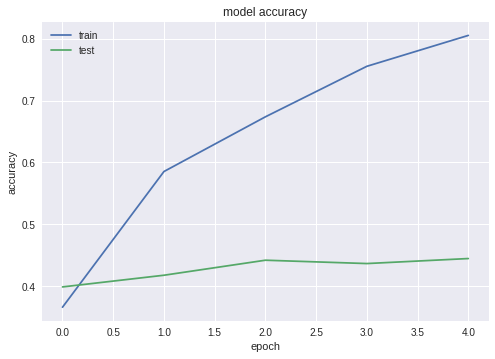

450/450 [==============================] - 6s 13ms/step
[1.1940823831823137, 0.49777777777777776]
0.09955555555555555


In [19]:
# Create LSTM model

# Simple LSTM model with 1 LSTM layer and no dense layers
# LSTM layer accepts data in the form (samples, timesteps, features)

num_epochs = 5

def make_LSTM():
    # input is of the form: (sample, spatial, temporal)
    model = Sequential()
    model.add(Permute((2, 1), input_shape=(22, 1000)))
    
    # LSTM layers
    model.add(LSTM(128, dropout=0.0, recurrent_dropout=0.0, return_sequences=True))
    
    # Dense layers
    model.add(Flatten())
    model.add(Dense(units=4, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='SGD',
                  metrics=['accuracy'])
    
    print(model.summary())
    
    return model

avg_acc = 0
for train_idx, test_idx in tt_splits:
    X_train = X[train_idx]
    y_train = y_cat[train_idx]
    X_test = X[test_idx]
    y_test = y_cat[test_idx]
    
    model = make_LSTM()
    
    history = model.fit(X_train, y_train, validation_split=val_split, epochs=num_epochs, batch_size=batch_size)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    metrics = model.evaluate(X_test, y_test, batch_size=batch_size)
    avg_acc += metrics[1]
    print(metrics)
    break

print(avg_acc)

The result was similar, but trained much quicker

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_8 (Permute)          (None, 1000, 22)          0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 1000, 128)         77312     
_________________________________________________________________
flatten_8 (Flatten)          (None, 128000)            0         
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 512004    
Total params: 589,316
Trainable params: 589,316
Non-trainable params: 0
_________________________________________________________________
None
Train on 1483 samples, validate on 371 samples
Epoch 1/5
1483/1483 [==============================] - 84s 57ms/step - loss: 1.3656 - acc: 0.3358 - val_loss: 1.3115 - val_acc: 0.3962
Epoch 2/5
1376/1483 [==========================>...] - ETA: 5s - loss: 1.0949 - a

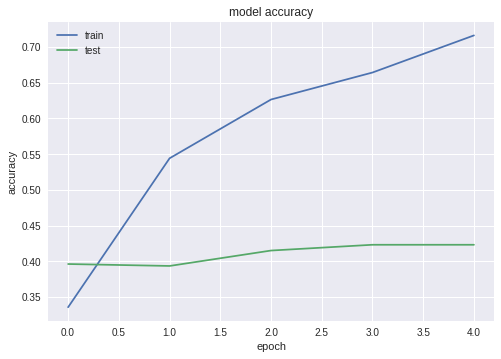

450/450 [==============================] - 6s 14ms/step
[1.2352894277042812, 0.4711111111111111]
0.4711111111111111


In [27]:
# Create LSTM model

# Simple LSTM model with stacked LSTM layers (inspiration from NLP) - 3 layers
# LSTM layer accepts data in the form (samples, timesteps, features)

num_epochs = 5

def make_LSTM():
    # input is of the form: (sample, spatial, temporal)
    model = Sequential()
    model.add(Permute((2, 1), input_shape=(22, 1000)))
    
    # LSTM layers
    model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.0, return_sequences=True))
    
    # Dense layers
    model.add(Flatten())
    model.add(Dense(units=4, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='SGD',
                  metrics=['accuracy'])
    
    print(model.summary())
    
    return model

avg_acc = 0
for train_idx, test_idx in tt_splits:
    X_train = X[train_idx]
    y_train = y_cat[train_idx]
    X_test = X[test_idx]
    y_test = y_cat[test_idx]
    
    model = make_LSTM()
    
    history = model.fit(X_train, y_train, validation_split=val_split, epochs=num_epochs, batch_size=batch_size)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    metrics = model.evaluate(X_test, y_test, batch_size=batch_size)
    avg_acc += metrics[1]
    print(metrics)
    break

print(avg_acc)

Training is very slow, and dropout doesn't help that much.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_10 (Permute)         (None, 1000, 22)          0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 1000, 32)          7040      
_________________________________________________________________
lstm_19 (LSTM)               (None, 1000, 32)          8320      
_________________________________________________________________
lstm_20 (LSTM)               (None, 1000, 32)          8320      
_________________________________________________________________
flatten_10 (Flatten)         (None, 32000)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 4)                 128004    
Total params: 151,684
Trainable params: 151,684
Non-trainable params: 0
_________________________________________________________________
None

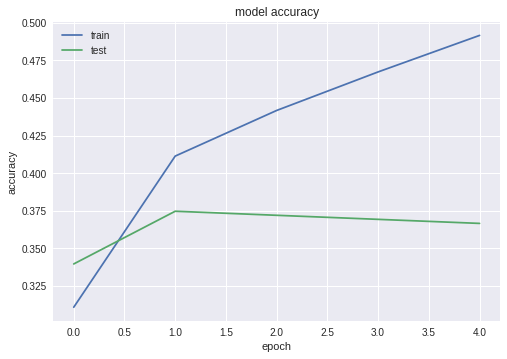

450/450 [==============================] - 15s 33ms/step
[1.2781465938356187, 0.39555555555555555]
0.39555555555555555


In [29]:
# Create LSTM model

# Simple LSTM model with stacked LSTM layers (inspiration from NLP) - many layers, with dropout
# LSTM layer accepts data in the form (samples, timesteps, features)

num_epochs = 5

def make_LSTM():
    # input is of the form: (sample, spatial, temporal)
    model = Sequential()
    model.add(Permute((2, 1), input_shape=(22, 1000)))
    
    # LSTM layers
    model.add(LSTM(32, return_sequences=True))
    model.add(LSTM(32, return_sequences=True))
    model.add(LSTM(32, return_sequences=True))
    
    # Dense layers
    model.add(Flatten())
    model.add(Dense(units=4, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='SGD',
                  metrics=['accuracy'])
    
    print(model.summary())
    
    return model

avg_acc = 0
for train_idx, test_idx in tt_splits:
    X_train = X[train_idx]
    y_train = y_cat[train_idx]
    X_test = X[test_idx]
    y_test = y_cat[test_idx]
    
    model = make_LSTM()
    
    history = model.fit(X_train, y_train, validation_split=val_split, epochs=num_epochs, batch_size=batch_size)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    metrics = model.evaluate(X_test, y_test, batch_size=batch_size)
    avg_acc += metrics[1]
    print(metrics)
    break

print(avg_acc)

Training is even slower, and improvement is not that much.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_11 (Permute)         (None, 1000, 22)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 1000, 32)          5280      
_________________________________________________________________
gru_2 (GRU)                  (None, 1000, 32)          6240      
_________________________________________________________________
flatten_11 (Flatten)         (None, 32000)             0         
_________________________________________________________________
dense_14 (Dense)             (None, 4)                 128004    
Total params: 139,524
Trainable params: 139,524
Non-trainable params: 0
_________________________________________________________________
None
Train on 1483 samples, validate on 371 samples
Epoch 1/5
1483/1483 [==============================] - 131s 89ms/step - loss: 1.3592

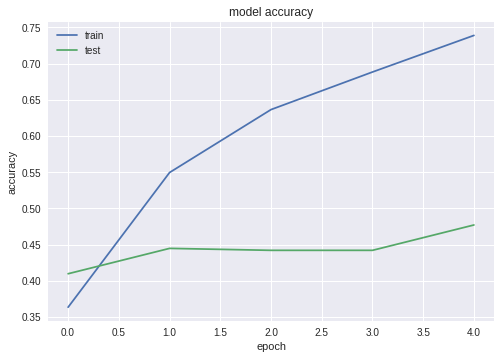

450/450 [==============================] - 8s 17ms/step
[1.1975412130355836, 0.4888888888888889]
0.4888888888888889


In [32]:
# Create GRU model

# GRU uses less params than LSTM, for faster training
# Simple GRU model with stacked GRU layers (inspiration from NLP) - 3 layers, with dropout
# GRU layer accepts data in the form (samples, timesteps, features)

def make_GRU():
    # input is of the form: (sample, spatial, temporal)
    model = Sequential()
    model.add(Permute((2, 1), input_shape=(22, 1000)))
    
    # GRU layers
    model.add(GRU(32, return_sequences=True))
    model.add(GRU(32, return_sequences=True))
    
    # Dense layers
    model.add(Flatten())
    model.add(Dense(units=4, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='SGD',
                  metrics=['accuracy'])
    
    print(model.summary())
    
    return model

avg_acc = 0
for train_idx, test_idx in tt_splits:
    X_train = X[train_idx]
    y_train = y_cat[train_idx]
    X_test = X[test_idx]
    y_test = y_cat[test_idx]
    
    model = make_GRU()
    
    history = model.fit(X_train, y_train, validation_split=val_split, epochs=num_epochs, batch_size=batch_size)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    metrics = model.evaluate(X_test, y_test, batch_size=batch_size)
    avg_acc += metrics[1]
    print(metrics)
    break

print(avg_acc)

GRU is a little bit faster, still similar accuracy

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_25 (Permute)         (None, 1000, 22)          0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 991, 25)           5525      
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 982, 25)           6275      
_________________________________________________________________
permute_26 (Permute)         (None, 25, 982)           0         
_________________________________________________________________
gru_27 (GRU)                 (None, 25, 32)            97440     
_________________________________________________________________
gru_28 (GRU)                 (None, 25, 32)            6240      
_________________________________________________________________
flatten_24 (Flatten)         (None, 800)               0         
__________

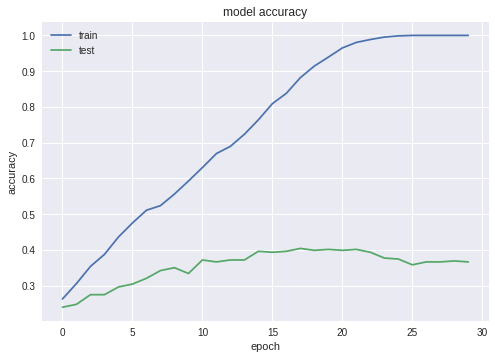

450/450 [==============================] - 0s 891us/step
[2.3261600787109797, 0.3688888888888889]
0.3688888888888889


In [45]:
num_epochs = 30

# Create GRU model

# GRU uses less params than LSTM, for faster training
# Simple GRU model with stacked GRU layers (inspiration from NLP) - 3 layers, with dropout
# GRU layer accepts data in the form (samples, timesteps, features)

def make_GRU():
    # input is of the form: (sample, spatial, temporal)
    model = Sequential()
    model.add(Permute((2, 1), input_shape=(22, 1000)))
    
    model.add(Conv1D(filters = 25, kernel_size = 10, activation = 'elu'))
    model.add(Conv1D(filters = 25, kernel_size = 10, activation = 'elu'))
    
    model.add(Permute((2, 1)))
    
    # GRU layers
    model.add(GRU(32, return_sequences=True))
    model.add(GRU(32, return_sequences=True))
    
    # Dense layers
    model.add(Flatten())
    model.add(Dense(units=4, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='SGD',
                  metrics=['accuracy'])
    
    print(model.summary())
    
    return model

# make_GRU()
  
avg_acc = 0
for train_idx, test_idx in tt_splits:
    X_train = X[train_idx]
    y_train = y_cat[train_idx]
    X_test = X[test_idx]
    y_test = y_cat[test_idx]
    
    model = make_GRU()
    
    history = model.fit(X_train, y_train, validation_split=val_split, epochs=num_epochs, batch_size=batch_size)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    metrics = model.evaluate(X_test, y_test, batch_size=batch_size)
    avg_acc += metrics[1]
    print(metrics)
    break

print(avg_acc)

Model trained much faster than previous ones, but still overfit, so we can try some regularization techniques.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_47 (Permute)         (None, 1000, 22)          0         
_________________________________________________________________
conv1d_39 (Conv1D)           (None, 976, 64)           35264     
_________________________________________________________________
dropout_22 (Dropout)         (None, 976, 64)           0         
_________________________________________________________________
conv1d_40 (Conv1D)           (None, 952, 64)           102464    
_________________________________________________________________
dropout_23 (Dropout)         (None, 952, 64)           0         
_________________________________________________________________
permute_48 (Permute)         (None, 64, 952)           0         
_________________________________________________________________
gru_55 (GRU)                 (None, 64, 128)           415104    
__________

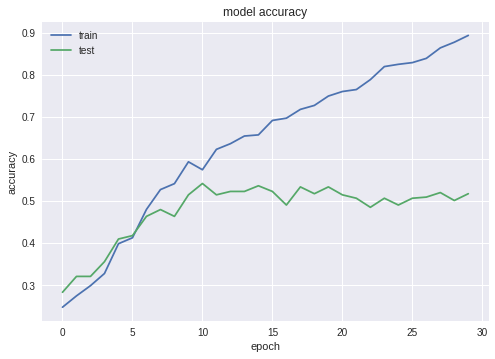

450/450 [==============================] - 1s 3ms/step
[2.0114419746398924, 0.4711111111111111]
0.4711111111111111


In [57]:
num_epochs = 30

# Create GRU model

# GRU uses less params than LSTM, for faster training
# Simple GRU model with stacked GRU layers (inspiration from NLP) - 3 layers, with dropout
# GRU layer accepts data in the form (samples, timesteps, features)

def make_GRU():
    # input is of the form: (sample, spatial, temporal)
    model = Sequential()
    model.add(Permute((2, 1), input_shape=(22, 1000)))
    
    model.add(Conv1D(filters = 64, kernel_size = 25, activation = 'elu'))
    model.add(Dropout(0.4))
    model.add(Conv1D(filters = 64, kernel_size = 25, activation = 'elu'))
    model.add(Dropout(0.4))
    
    model.add(Permute((2, 1)))
    
    # GRU layers
    model.add(GRU(128, return_sequences=True))
    model.add(GRU(128, return_sequences=True))
    model.add(GRU(64, return_sequences=True))
    
    model.add(Permute((2, 1)))
    
    model.add(Conv1D(filters = 64, kernel_size = 25, activation = 'elu'))
    model.add(Dropout(0.4))
    model.add(Conv1D(filters = 64, kernel_size = 25, activation = 'elu'))
    model.add(Dropout(0.4))
    
    model.add(Permute((2, 1)))
    
    # Dense layers
    model.add(Flatten())
    model.add(Dense(units=4, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='SGD',
                  metrics=['accuracy'])
    
    print(model.summary())
    
    return model

# make_GRU()
  
avg_acc = 0
for train_idx, test_idx in tt_splits:
    X_train = X[train_idx]
    y_train = y_cat[train_idx]
    X_test = X[test_idx]
    y_test = y_cat[test_idx]
    
    model = make_GRU()
    
    history = model.fit(X_train, y_train, validation_split=val_split, epochs=num_epochs, batch_size=batch_size)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    metrics = model.evaluate(X_test, y_test, batch_size=batch_size)
    avg_acc += metrics[1]
    print(metrics)
    break

print(avg_acc)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_52 (Permute)         (None, 1000, 22)          0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 976, 64)           35264     
_________________________________________________________________
dropout_26 (Dropout)         (None, 976, 64)           0         
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 952, 64)           102464    
_________________________________________________________________
dropout_27 (Dropout)         (None, 952, 64)           0         
_________________________________________________________________
permute_53 (Permute)         (None, 64, 952)           0         
_________________________________________________________________
lstm_24 (LSTM)               (None, 64, 128)           553472    
__________

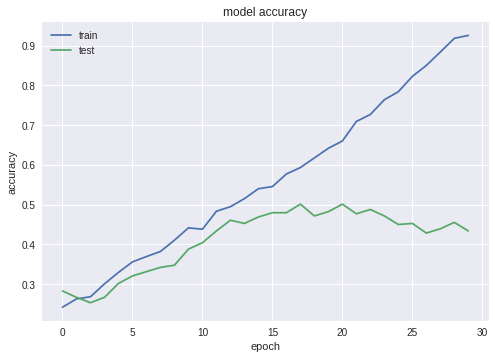

450/450 [==============================] - 2s 4ms/step
[2.383791153695848, 0.4711111111111111]
0.4711111111111111


In [60]:
num_epochs = 30

# Create GRU model

# GRU uses less params than LSTM, for faster training
# Simple GRU model with stacked GRU layers (inspiration from NLP) - 3 layers, with dropout
# GRU layer accepts data in the form (samples, timesteps, features)

def make_LSTM():
    # input is of the form: (sample, spatial, temporal)
    model = Sequential()
    model.add(Permute((2, 1), input_shape=(22, 1000)))
    
    model.add(Conv1D(filters = 64, kernel_size = 25, activation = 'elu'))
    model.add(Dropout(0.4))
    model.add(Conv1D(filters = 64, kernel_size = 25, activation = 'elu'))
    model.add(Dropout(0.4))
    
    model.add(Permute((2, 1)))
    
    # GRU layers
    model.add(LSTM(128, return_sequences=True))
    model.add(LSTM(128, return_sequences=True))
    model.add(LSTM(64, return_sequences=True))
    
    model.add(Permute((2, 1)))
    
    model.add(Conv1D(filters = 64, kernel_size = 25, activation = 'elu'))
    model.add(Dropout(0.4))
    model.add(Conv1D(filters = 64, kernel_size = 25, activation = 'elu'))
    model.add(Dropout(0.4))
    
    model.add(Permute((2, 1)))
    
    # Dense layers
    model.add(Flatten())
    model.add(Dense(units=4, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='SGD',
                  metrics=['accuracy'])
    
    print(model.summary())
    
    return model

# make_GRU()
  
avg_acc = 0
for train_idx, test_idx in tt_splits:
    X_train = X[train_idx]
    y_train = y_cat[train_idx]
    X_test = X[test_idx]
    y_test = y_cat[test_idx]
    
    model = make_LSTM()
    
    history = model.fit(X_train, y_train, validation_split=val_split, epochs=num_epochs, batch_size=batch_size)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    metrics = model.evaluate(X_test, y_test, batch_size=batch_size)
    avg_acc += metrics[1]
    print(metrics)
    break

print(avg_acc)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_63 (Permute)         (None, 1000, 22)          0         
_________________________________________________________________
reshape_12 (Reshape)         (None, 1000, 22, 1)       0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 991, 22, 25)       275       
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 991, 1, 25)        13775     
_________________________________________________________________
batch_normalization_21 (Batc (None, 991, 1, 25)        100       
_________________________________________________________________
activation_21 (Activation)   (None, 991, 1, 25)        0         
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 330, 1, 25)        0         
__________

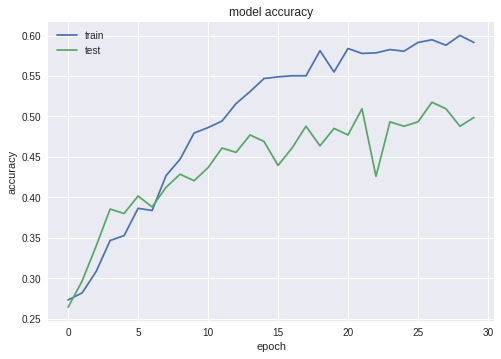

450/450 [==============================] - 2s 4ms/step
[1.0866218821207683, 0.5333333333333333]
0.5333333333333333


In [75]:
num_epochs = 30

# Create GRU model

# GRU uses less params than LSTM, for faster training
# Simple GRU model with stacked GRU layers (inspiration from NLP) - 3 layers, with dropout
# GRU layer accepts data in the form (samples, timesteps, features)

def make_GRU():
    # input is of the form: (sample, spatial, temporal)
    model = Sequential()
    
    model.add(Permute((2, 1), input_shape=(22, 1000)))
    model.add(Reshape((1000, 22, 1)))
    
    model.add(Conv2D(filters=25, kernel_size=(10,1), kernel_initializer = 'glorot_normal', strides=1, data_format="channels_last"))
    #print(model.output_shape)
    model.add(Conv2D(filters=25, kernel_size=(1,22), kernel_initializer = 'glorot_normal' ))
    model.add(BatchNormalization())
    model.add(Activation(activation = 'elu'))
    model.add(MaxPooling2D(pool_size = (3,1), strides = (3,1)))
    model.add(Dropout(0.5))

    # Conv Pool Block 2
    model.add(Conv2D(filters = 50, kernel_size = (10,1), activation = 'elu', kernel_initializer = 'glorot_normal'))
    model.add(BatchNormalization())
    model.add(Activation(activation = 'elu'))
    model.add(MaxPooling2D(pool_size = (3,1), strides = (3,1)))
    model.add(Dropout(0.5))
    
    model.add(Permute((1, 3, 2)))
    model.add(Reshape((107, 50)))
    
    # GRU layers
    model.add(GRU(32, return_sequences=True))
    model.add(GRU(32, return_sequences=True))
    model.add(GRU(32, return_sequences=True))
    model.add(GRU(32, return_sequences=True))
    
    # Dense layers
    model.add(Flatten())
    model.add(Dense(units=4, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='SGD',
                  metrics=['accuracy'])
    
    print(model.summary())
    
    return model

# make_GRU()
  
avg_acc = 0
for train_idx, test_idx in tt_splits:
    X_train = X[train_idx]
    y_train = y_cat[train_idx]
    X_test = X[test_idx]
    y_test = y_cat[test_idx]
    
    model = make_GRU()
    
    history = model.fit(X_train, y_train, validation_split=val_split, epochs=num_epochs, batch_size=batch_size)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    metrics = model.evaluate(X_test, y_test, batch_size=batch_size)
    avg_acc += metrics[1]
    print(metrics)
    break

print(avg_acc)

This model can probably be trained for more epochs or at a higher learning rate - the validation accuracy is still increasing, and the training accuracy is not increasing much faster than the val accuracy. Adding the convolutional layers at the start was good (because it preprocessed the data).

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_1 (Permute)          (None, 1000, 22)          0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 1000, 22, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 991, 22, 25)       275       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 991, 1, 25)        13775     
_________________________________________________________________
batch_normalization_1 (Batch (None, 991, 1, 25)        100       
_________________________________________________________________
activation_1 (Activation)    (None, 991, 1, 25)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 330, 1, 25)        0         
__________

Epoch 38/60
1483/1483 [==============================] - 43s 29ms/step - loss: 0.8856 - acc: 0.6345 - val_loss: 1.0436 - val_acc: 0.5687
Epoch 39/60
1483/1483 [==============================] - 43s 29ms/step - loss: 0.8808 - acc: 0.6440 - val_loss: 1.0602 - val_acc: 0.5768
Epoch 40/60
1483/1483 [==============================] - 43s 29ms/step - loss: 0.8766 - acc: 0.6460 - val_loss: 1.0453 - val_acc: 0.5606
Epoch 41/60
1483/1483 [==============================] - 43s 29ms/step - loss: 0.8584 - acc: 0.6453 - val_loss: 1.0316 - val_acc: 0.5741
Epoch 42/60
1483/1483 [==============================] - 43s 29ms/step - loss: 0.8550 - acc: 0.6608 - val_loss: 1.0159 - val_acc: 0.5822
Epoch 43/60
1483/1483 [==============================] - 42s 29ms/step - loss: 0.8773 - acc: 0.6473 - val_loss: 1.0424 - val_acc: 0.5553
Epoch 44/60
1483/1483 [==============================] - 43s 29ms/step - loss: 0.8488 - acc: 0.6440 - val_loss: 1.1120 - val_acc: 0.5741
Epoch 45/60
1483/1483 [==================

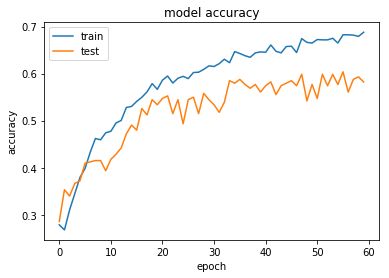

450/450 [==============================] - 4s 8ms/step
[1.0648642179701064, 0.6]
0.6


In [4]:
num_epochs = 60

# Create GRU model

# GRU uses less params than LSTM, for faster training
# Simple GRU model with stacked GRU layers (inspiration from NLP) - 3 layers, with dropout
# GRU layer accepts data in the form (samples, timesteps, features)

def make_GRU():
    # input is of the form: (sample, spatial, temporal)
    model = Sequential()
    
    model.add(Permute((2, 1), input_shape=(22, 1000)))
    model.add(Reshape((1000, 22, 1)))
    
    model.add(Conv2D(filters=25, kernel_size=(10,1), kernel_initializer = 'glorot_normal', strides=1, data_format="channels_last"))
    #print(model.output_shape)
    model.add(Conv2D(filters=25, kernel_size=(1,22), kernel_initializer = 'glorot_normal' ))
    model.add(BatchNormalization())
    model.add(Activation(activation = 'elu'))
    model.add(MaxPooling2D(pool_size = (3,1), strides = (3,1)))
    model.add(Dropout(0.5))

    # Conv Pool Block 2
    model.add(Conv2D(filters = 50, kernel_size = (10,1), activation = 'elu', kernel_initializer = 'glorot_normal'))
    model.add(BatchNormalization())
    model.add(Activation(activation = 'elu'))
    model.add(MaxPooling2D(pool_size = (3,1), strides = (3,1)))
    model.add(Dropout(0.5))
    
    model.add(Permute((1, 3, 2)))
    model.add(Reshape((107, 50)))
    
    # GRU layers
    model.add(GRU(32, return_sequences=True))
    model.add(GRU(32, return_sequences=True))
    model.add(GRU(32, return_sequences=True))
    model.add(GRU(32, return_sequences=True))
    
    # Dense layers
    model.add(Flatten())
    model.add(Dense(units=4, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='SGD',
                  metrics=['accuracy'])
    
    print(model.summary())
    
    return model

# make_GRU()
  
avg_acc = 0
for train_idx, test_idx in tt_splits:
    X_train = X[train_idx]
    y_train = y_cat[train_idx]
    X_test = X[test_idx]
    y_test = y_cat[test_idx]
    
    model = make_GRU()
    
    history = model.fit(X_train, y_train, validation_split=val_split, epochs=num_epochs, batch_size=batch_size)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    metrics = model.evaluate(X_test, y_test, batch_size=batch_size)
    avg_acc += metrics[1]
    print(metrics)
    break

print(avg_acc)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_3 (Permute)          (None, 1000, 22)          0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 1000, 22, 1)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 991, 22, 25)       275       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 991, 1, 25)        13775     
_________________________________________________________________
batch_normalization_3 (Batch (None, 991, 1, 25)        100       
_________________________________________________________________
activation_3 (Activation)    (None, 991, 1, 25)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 330, 1, 25)        0         
__________

1483/1483 [==============================] - 41s 27ms/step - loss: 0.1449 - acc: 0.9717 - val_loss: 1.2248 - val_acc: 0.5768
Epoch 40/50
1483/1483 [==============================] - 40s 27ms/step - loss: 0.1338 - acc: 0.9757 - val_loss: 1.3054 - val_acc: 0.5445
Epoch 41/50
1483/1483 [==============================] - 39s 26ms/step - loss: 0.1287 - acc: 0.9751 - val_loss: 1.2556 - val_acc: 0.5903
Epoch 42/50
1483/1483 [==============================] - 39s 26ms/step - loss: 0.1159 - acc: 0.9798 - val_loss: 1.2606 - val_acc: 0.5606
Epoch 43/50
1483/1483 [==============================] - 39s 26ms/step - loss: 0.1052 - acc: 0.9825 - val_loss: 1.3213 - val_acc: 0.5633
Epoch 44/50
1483/1483 [==============================] - 39s 26ms/step - loss: 0.1008 - acc: 0.9818 - val_loss: 1.2741 - val_acc: 0.5741
Epoch 45/50
1483/1483 [==============================] - 39s 26ms/step - loss: 0.0950 - acc: 0.9845 - val_loss: 1.3341 - val_acc: 0.5526
Epoch 46/50
1483/1483 [==============================

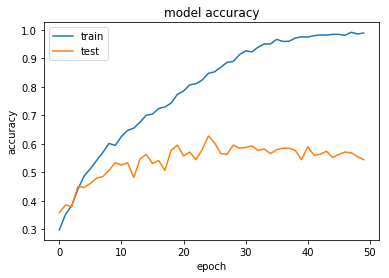

450/450 [==============================] - 4s 10ms/step
[1.366537348429362, 0.5977777777777777]
0.5977777777777777


In [5]:
num_epochs = 50

# Create GRU model

# GRU uses less params than LSTM, for faster training
# Simple GRU model with stacked GRU layers (inspiration from NLP) - 3 layers, with dropout
# GRU layer accepts data in the form (samples, timesteps, features)

def make_GRU():
    # input is of the form: (sample, spatial, temporal)
    model = Sequential()
    
    model.add(Permute((2, 1), input_shape=(22, 1000)))
    model.add(Reshape((1000, 22, 1)))
    
    model.add(Conv2D(filters=25, kernel_size=(10,1), kernel_initializer = 'glorot_normal', strides=1, data_format="channels_last"))
    #print(model.output_shape)
    model.add(Conv2D(filters=25, kernel_size=(1,22), kernel_initializer = 'glorot_normal' ))
    model.add(BatchNormalization())
    model.add(Activation(activation = 'elu'))
    model.add(MaxPooling2D(pool_size = (3,1), strides = (3,1)))
    model.add(Dropout(0.5))

    # Conv Pool Block 2
    model.add(Conv2D(filters = 50, kernel_size = (10,1), activation = 'elu', kernel_initializer = 'glorot_normal'))
    model.add(BatchNormalization())
    model.add(Activation(activation = 'elu'))
    model.add(MaxPooling2D(pool_size = (3,1), strides = (3,1)))
    model.add(Dropout(0.5))
    
    model.add(Permute((1, 3, 2)))
    model.add(Reshape((107, 50)))
    
    # GRU layers
    model.add(GRU(256, return_sequences=True))
    
    # Dense layers
    model.add(Flatten())
    model.add(Dense(units=64, activation='relu'))
    model.add(Dense(units=4, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='SGD',
                  metrics=['accuracy'])
    
    print(model.summary())
    
    return model

# make_GRU()
  
avg_acc = 0
for train_idx, test_idx in tt_splits:
    X_train = X[train_idx]
    y_train = y_cat[train_idx]
    X_test = X[test_idx]
    y_test = y_cat[test_idx]
    
    model = make_GRU()
    
    history = model.fit(X_train, y_train, validation_split=val_split, epochs=num_epochs, batch_size=batch_size)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    metrics = model.evaluate(X_test, y_test, batch_size=batch_size)
    avg_acc += metrics[1]
    print(metrics)
    break

print(avg_acc)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_5 (Permute)          (None, 1000, 22)          0         
_________________________________________________________________
reshape_5 (Reshape)          (None, 1000, 22, 1)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 991, 22, 25)       275       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 991, 1, 25)        13775     
_________________________________________________________________
batch_normalization_5 (Batch (None, 991, 1, 25)        100       
_________________________________________________________________
activation_5 (Activation)    (None, 991, 1, 25)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 330, 1, 25)        0         
__________

1483/1483 [==============================] - 39s 26ms/step - loss: 0.1494 - acc: 0.9724 - val_loss: 1.1810 - val_acc: 0.5849
Epoch 40/50
1483/1483 [==============================] - 39s 26ms/step - loss: 0.1536 - acc: 0.9629 - val_loss: 1.1711 - val_acc: 0.6011
Epoch 41/50
1483/1483 [==============================] - 39s 26ms/step - loss: 0.1412 - acc: 0.9744 - val_loss: 1.3826 - val_acc: 0.5391
Epoch 42/50
1483/1483 [==============================] - 39s 26ms/step - loss: 0.1133 - acc: 0.9804 - val_loss: 1.2152 - val_acc: 0.5957
Epoch 43/50
1483/1483 [==============================] - 39s 26ms/step - loss: 0.1163 - acc: 0.9825 - val_loss: 1.3144 - val_acc: 0.5633
Epoch 44/50
1483/1483 [==============================] - 39s 26ms/step - loss: 0.1034 - acc: 0.9825 - val_loss: 1.2691 - val_acc: 0.5768
Epoch 45/50
1483/1483 [==============================] - 40s 27ms/step - loss: 0.0942 - acc: 0.9838 - val_loss: 1.2773 - val_acc: 0.5822
Epoch 46/50
1483/1483 [==============================

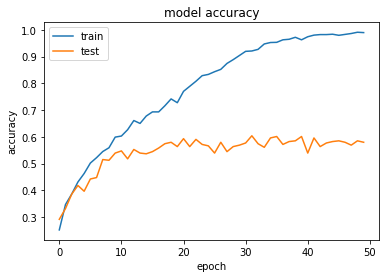

450/450 [==============================] - 4s 10ms/step
[1.5613614077038236, 0.5555555555555556]
0.5555555555555556


In [6]:
num_epochs = 50

# Create GRU model

# GRU uses less params than LSTM, for faster training
# Simple GRU model with stacked GRU layers (inspiration from NLP) - 3 layers, with dropout
# GRU layer accepts data in the form (samples, timesteps, features)

def make_GRU():
    # input is of the form: (sample, spatial, temporal)
    model = Sequential()
    
    model.add(Permute((2, 1), input_shape=(22, 1000)))
    model.add(Reshape((1000, 22, 1)))
    
    model.add(Conv2D(filters=25, kernel_size=(10,1), kernel_initializer = 'glorot_normal', strides=1, data_format="channels_last"))
    #print(model.output_shape)
    model.add(Conv2D(filters=25, kernel_size=(1,22), kernel_initializer = 'glorot_normal' ))
    model.add(BatchNormalization())
    model.add(Activation(activation = 'elu'))
    model.add(MaxPooling2D(pool_size = (3,1), strides = (3,1)))
    model.add(Dropout(0.5))

    # Conv Pool Block 2
    model.add(Conv2D(filters = 50, kernel_size = (10,1), activation = 'elu', kernel_initializer = 'glorot_normal'))
    model.add(BatchNormalization())
    model.add(Activation(activation = 'elu'))
    model.add(MaxPooling2D(pool_size = (3,1), strides = (3,1)))
    model.add(Dropout(0.5))
    
    model.add(Permute((1, 3, 2)))
    model.add(Reshape((107, 50)))
    
    # GRU layers
    model.add(GRU(256, return_sequences=True))
    
    # Dense layers
    model.add(Flatten())
    model.add(Dense(units=64, activation='relu'))
    model.add(Dense(units=4, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='SGD',
                  metrics=['accuracy'])
    
    print(model.summary())
    
    return model

# make_GRU()
  
avg_acc = 0
for train_idx, test_idx in tt_splits:
    X_train = X[train_idx]
    y_train = y_cat[train_idx]
    X_test = X[test_idx]
    y_test = y_cat[test_idx]
    
    model = make_GRU()
    
    history = model.fit(X_train, y_train, validation_split=val_split, epochs=num_epochs, batch_size=batch_size)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    metrics = model.evaluate(X_test, y_test, batch_size=batch_size)
    avg_acc += metrics[1]
    print(metrics)
    break

print(avg_acc)

Looks like the network with conv layers and deep stacked GRU layers (and no FC layers) worked the best, but is still underfitting. Lets try again with more epochs, and also more stacked GRU layers.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_7 (Permute)          (None, 1000, 22)          0         
_________________________________________________________________
reshape_7 (Reshape)          (None, 1000, 22, 1)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 991, 22, 25)       275       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 991, 1, 25)        13775     
_________________________________________________________________
batch_normalization_7 (Batch (None, 991, 1, 25)        100       
_________________________________________________________________
activation_7 (Activation)    (None, 991, 1, 25)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 330, 1, 25)        0         
__________

1483/1483 [==============================] - 49s 33ms/step - loss: 0.9471 - acc: 0.6150 - val_loss: 1.0997 - val_acc: 0.5553
Epoch 38/100
1483/1483 [==============================] - 51s 35ms/step - loss: 0.9410 - acc: 0.6170 - val_loss: 1.0327 - val_acc: 0.5849
Epoch 39/100
1483/1483 [==============================] - 49s 33ms/step - loss: 0.9269 - acc: 0.6177 - val_loss: 1.0591 - val_acc: 0.5633
Epoch 40/100
1483/1483 [==============================] - 43s 29ms/step - loss: 0.9190 - acc: 0.6264 - val_loss: 1.0612 - val_acc: 0.5795
Epoch 41/100
1483/1483 [==============================] - 43s 29ms/step - loss: 0.9164 - acc: 0.6332 - val_loss: 1.0902 - val_acc: 0.5499
Epoch 42/100
1483/1483 [==============================] - 43s 29ms/step - loss: 0.9259 - acc: 0.6264 - val_loss: 1.0388 - val_acc: 0.5903
Epoch 43/100
1483/1483 [==============================] - 45s 31ms/step - loss: 0.9118 - acc: 0.6413 - val_loss: 1.1811 - val_acc: 0.5094
Epoch 44/100
1483/1483 [=======================

1483/1483 [==============================] - 54s 36ms/step - loss: 0.6781 - acc: 0.7431 - val_loss: 1.0362 - val_acc: 0.6173
Epoch 97/100
1483/1483 [==============================] - 50s 34ms/step - loss: 0.6697 - acc: 0.7465 - val_loss: 1.0356 - val_acc: 0.6119
Epoch 98/100
1483/1483 [==============================] - 49s 33ms/step - loss: 0.6725 - acc: 0.7431 - val_loss: 1.0467 - val_acc: 0.6253
Epoch 99/100
1483/1483 [==============================] - 46s 31ms/step - loss: 0.6689 - acc: 0.7478 - val_loss: 1.0290 - val_acc: 0.6253
Epoch 100/100
1483/1483 [==============================] - 44s 29ms/step - loss: 0.6501 - acc: 0.7552 - val_loss: 1.0599 - val_acc: 0.6011


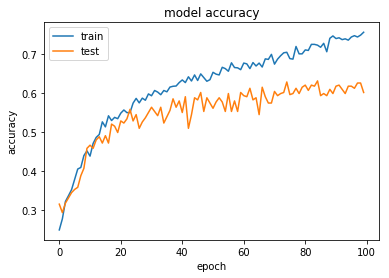

450/450 [==============================] - 4s 8ms/step
[1.0367252789603338, 0.6066666666666667]
0.6066666666666667


In [7]:
num_epochs = 100

# Create GRU model

# GRU uses less params than LSTM, for faster training
# Simple GRU model with stacked GRU layers (inspiration from NLP) - 3 layers, with dropout
# GRU layer accepts data in the form (samples, timesteps, features)

def make_GRU():
    # input is of the form: (sample, spatial, temporal)
    model = Sequential()
    
    model.add(Permute((2, 1), input_shape=(22, 1000)))
    model.add(Reshape((1000, 22, 1)))
    
    model.add(Conv2D(filters=25, kernel_size=(10,1), kernel_initializer = 'glorot_normal', strides=1, data_format="channels_last"))
    #print(model.output_shape)
    model.add(Conv2D(filters=25, kernel_size=(1,22), kernel_initializer = 'glorot_normal' ))
    model.add(BatchNormalization())
    model.add(Activation(activation = 'elu'))
    model.add(MaxPooling2D(pool_size = (3,1), strides = (3,1)))
    model.add(Dropout(0.5))

    # Conv Pool Block 2
    model.add(Conv2D(filters = 50, kernel_size = (10,1), activation = 'elu', kernel_initializer = 'glorot_normal'))
    model.add(BatchNormalization())
    model.add(Activation(activation = 'elu'))
    model.add(MaxPooling2D(pool_size = (3,1), strides = (3,1)))
    model.add(Dropout(0.5))
    
    model.add(Permute((1, 3, 2)))
    model.add(Reshape((107, 50)))
    
    # GRU layers
    model.add(GRU(32, return_sequences=True))
    model.add(GRU(32, return_sequences=True))
    model.add(GRU(32, return_sequences=True))
    model.add(GRU(32, return_sequences=True))
    
    # Dense layers
    model.add(Flatten())
    model.add(Dense(units=4, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='SGD',
                  metrics=['accuracy'])
    
    print(model.summary())
    
    return model

# make_GRU()
  
avg_acc = 0
for train_idx, test_idx in tt_splits:
    X_train = X[train_idx]
    y_train = y_cat[train_idx]
    X_test = X[test_idx]
    y_test = y_cat[test_idx]
    
    model = make_GRU()
    
    history = model.fit(X_train, y_train, validation_split=val_split, epochs=num_epochs, batch_size=batch_size)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    metrics = model.evaluate(X_test, y_test, batch_size=batch_size)
    avg_acc += metrics[1]
    print(metrics)
    break

print(avg_acc)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_9 (Permute)          (None, 1000, 22)          0         
_________________________________________________________________
reshape_9 (Reshape)          (None, 1000, 22, 1)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 991, 22, 25)       275       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 991, 1, 25)        13775     
_________________________________________________________________
batch_normalization_9 (Batch (None, 991, 1, 25)        100       
_________________________________________________________________
activation_9 (Activation)    (None, 991, 1, 25)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 330, 1, 25)        0         
__________

Epoch 36/60
1483/1483 [==============================] - 58s 39ms/step - loss: 1.0114 - acc: 0.5765 - val_loss: 1.1157 - val_acc: 0.5337
Epoch 37/60
1483/1483 [==============================] - 55s 37ms/step - loss: 1.0115 - acc: 0.5684 - val_loss: 1.1043 - val_acc: 0.5606
Epoch 38/60
1483/1483 [==============================] - 59s 40ms/step - loss: 1.0112 - acc: 0.5765 - val_loss: 1.1018 - val_acc: 0.5445
Epoch 39/60
1483/1483 [==============================] - 62s 42ms/step - loss: 1.0000 - acc: 0.5840 - val_loss: 1.1068 - val_acc: 0.5364
Epoch 40/60
1483/1483 [==============================] - 72s 49ms/step - loss: 0.9964 - acc: 0.5941 - val_loss: 1.0890 - val_acc: 0.5499
Epoch 41/60
1483/1483 [==============================] - 60s 41ms/step - loss: 0.9977 - acc: 0.5900 - val_loss: 1.0618 - val_acc: 0.5364
Epoch 42/60
1483/1483 [==============================] - 56s 38ms/step - loss: 0.9958 - acc: 0.5799 - val_loss: 1.1355 - val_acc: 0.5418
Epoch 43/60
1483/1483 [==================

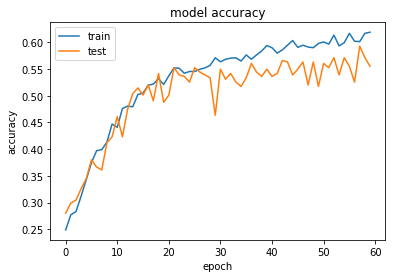

450/450 [==============================] - 4s 10ms/step
[1.0586408980687458, 0.5777777777777777]
0.5777777777777777


In [8]:
num_epochs = 60

# Create GRU model

# GRU uses less params than LSTM, for faster training
# Simple GRU model with stacked GRU layers (inspiration from NLP) - 3 layers, with dropout
# GRU layer accepts data in the form (samples, timesteps, features)

def make_GRU():
    # input is of the form: (sample, spatial, temporal)
    model = Sequential()
    
    model.add(Permute((2, 1), input_shape=(22, 1000)))
    model.add(Reshape((1000, 22, 1)))
    
    model.add(Conv2D(filters=25, kernel_size=(10,1), kernel_initializer = 'glorot_normal', strides=1, data_format="channels_last"))
    #print(model.output_shape)
    model.add(Conv2D(filters=25, kernel_size=(1,22), kernel_initializer = 'glorot_normal' ))
    model.add(BatchNormalization())
    model.add(Activation(activation = 'elu'))
    model.add(MaxPooling2D(pool_size = (3,1), strides = (3,1)))
    model.add(Dropout(0.5))

    # Conv Pool Block 2
    model.add(Conv2D(filters = 50, kernel_size = (10,1), activation = 'elu', kernel_initializer = 'glorot_normal'))
    model.add(BatchNormalization())
    model.add(Activation(activation = 'elu'))
    model.add(MaxPooling2D(pool_size = (3,1), strides = (3,1)))
    model.add(Dropout(0.5))
    
    model.add(Permute((1, 3, 2)))
    model.add(Reshape((107, 50)))
    
    # GRU layers # 6 layers instead of 4
    model.add(GRU(32, return_sequences=True))
    model.add(GRU(32, return_sequences=True))
    model.add(GRU(32, return_sequences=True))
    model.add(GRU(32, return_sequences=True))
    model.add(GRU(32, return_sequences=True))
    model.add(GRU(32, return_sequences=True))
    
    # Dense layers
    model.add(Flatten())
    model.add(Dense(units=4, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='SGD',
                  metrics=['accuracy'])
    
    print(model.summary())
    
    return model

# make_GRU()
  
avg_acc = 0
for train_idx, test_idx in tt_splits:
    X_train = X[train_idx]
    y_train = y_cat[train_idx]
    X_test = X[test_idx]
    y_test = y_cat[test_idx]
    
    model = make_GRU()
    
    history = model.fit(X_train, y_train, validation_split=val_split, epochs=num_epochs, batch_size=batch_size)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    metrics = model.evaluate(X_test, y_test, batch_size=batch_size)
    avg_acc += metrics[1]
    print(metrics)
    break

print(avg_acc)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_11 (Permute)         (None, 1000, 22)          0         
_________________________________________________________________
reshape_11 (Reshape)         (None, 1000, 22, 1)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 991, 22, 25)       275       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 991, 1, 25)        13775     
_________________________________________________________________
batch_normalization_11 (Batc (None, 991, 1, 25)        100       
_________________________________________________________________
activation_11 (Activation)   (None, 991, 1, 25)        0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 330, 1, 25)        0         
__________

1483/1483 [==============================] - 65s 44ms/step - loss: 0.9909 - acc: 0.5914 - val_loss: 1.0873 - val_acc: 0.5337
Epoch 36/120
1483/1483 [==============================] - 60s 40ms/step - loss: 0.9629 - acc: 0.6069 - val_loss: 1.1150 - val_acc: 0.5337
Epoch 37/120
1483/1483 [==============================] - 53s 36ms/step - loss: 0.9867 - acc: 0.5900 - val_loss: 1.1479 - val_acc: 0.5040
Epoch 38/120
1483/1483 [==============================] - 52s 35ms/step - loss: 0.9653 - acc: 0.6049 - val_loss: 1.1122 - val_acc: 0.5256
Epoch 39/120
1483/1483 [==============================] - 52s 35ms/step - loss: 0.9706 - acc: 0.5914 - val_loss: 1.2479 - val_acc: 0.4906
Epoch 40/120
1483/1483 [==============================] - 52s 35ms/step - loss: 0.9410 - acc: 0.6055 - val_loss: 1.1333 - val_acc: 0.5121
Epoch 41/120
1483/1483 [==============================] - 52s 35ms/step - loss: 0.9578 - acc: 0.6170 - val_loss: 1.1232 - val_acc: 0.5040
Epoch 42/120
1483/1483 [=======================

1483/1483 [==============================] - 51s 34ms/step - loss: 0.7726 - acc: 0.6871 - val_loss: 1.0745 - val_acc: 0.5553
Epoch 95/120
1483/1483 [==============================] - 51s 34ms/step - loss: 0.7833 - acc: 0.6844 - val_loss: 1.0357 - val_acc: 0.5660
Epoch 96/120
1483/1483 [==============================] - 51s 34ms/step - loss: 0.7780 - acc: 0.6790 - val_loss: 1.0755 - val_acc: 0.5903
Epoch 97/120
1483/1483 [==============================] - 51s 34ms/step - loss: 0.7719 - acc: 0.6979 - val_loss: 1.0666 - val_acc: 0.5876
Epoch 98/120
1483/1483 [==============================] - 51s 34ms/step - loss: 0.7706 - acc: 0.7013 - val_loss: 1.1406 - val_acc: 0.5687
Epoch 99/120
1483/1483 [==============================] - 50s 34ms/step - loss: 0.7717 - acc: 0.7013 - val_loss: 1.0278 - val_acc: 0.6065
Epoch 100/120
1483/1483 [==============================] - 51s 34ms/step - loss: 0.7595 - acc: 0.6993 - val_loss: 1.0826 - val_acc: 0.5795
Epoch 101/120
1483/1483 [=====================

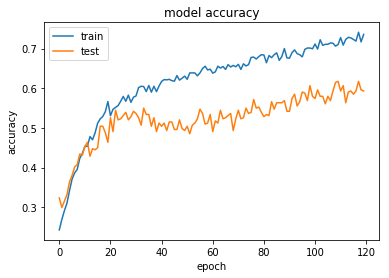

450/450 [==============================] - 4s 9ms/step
[1.081797431839837, 0.56]
0.56


In [11]:
num_epochs = 120

# Create GRU model

# GRU uses less params than LSTM, for faster training
# Simple GRU model with stacked GRU layers (inspiration from NLP) - 3 layers, with dropout
# GRU layer accepts data in the form (samples, timesteps, features)

def make_GRU():
    # input is of the form: (sample, spatial, temporal)
    model = Sequential()
    
    model.add(Permute((2, 1), input_shape=(22, 1000)))
    model.add(Reshape((1000, 22, 1)))
    
    model.add(Conv2D(filters=25, kernel_size=(10,1), kernel_initializer = 'glorot_normal', strides=1, data_format="channels_last"))
    #print(model.output_shape)
    model.add(Conv2D(filters=25, kernel_size=(1,22), kernel_initializer = 'glorot_normal' ))
    model.add(BatchNormalization())
    model.add(Activation(activation = 'elu'))
    model.add(MaxPooling2D(pool_size = (3,1), strides = (3,1)))
    model.add(Dropout(0.5))

    # Conv Pool Block 2
    model.add(Conv2D(filters = 50, kernel_size = (10,1), activation = 'elu', kernel_initializer = 'glorot_normal'))
    model.add(BatchNormalization())
    model.add(Activation(activation = 'elu'))
    model.add(MaxPooling2D(pool_size = (3,1), strides = (3,1)))
    model.add(Dropout(0.5))
    
    model.add(Permute((1, 3, 2)))
    model.add(Reshape((107, 50)))
    
    # GRU layers # 6 layers instead of 4
    model.add(GRU(32, return_sequences=True))
    model.add(GRU(32, return_sequences=True))
    model.add(GRU(32, return_sequences=True))
    model.add(GRU(32, return_sequences=True))
    model.add(GRU(32, return_sequences=True))
    model.add(GRU(32, return_sequences=True))
    
    # Dense layers
    model.add(Flatten())
    model.add(Dense(units=4, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='SGD',
                  metrics=['accuracy'])
    
    print(model.summary())
    
    return model

# make_GRU()
  
avg_acc = 0
for train_idx, test_idx in tt_splits:
    X_train = X[train_idx]
    y_train = y_cat[train_idx]
    X_test = X[test_idx]
    y_test = y_cat[test_idx]
    
    model = make_GRU()
    
    history = model.fit(X_train, y_train, validation_split=val_split, epochs=num_epochs, batch_size=batch_size)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    metrics = model.evaluate(X_test, y_test, batch_size=batch_size)
    avg_acc += metrics[1]
    print(metrics)
    break

print(avg_acc)

Train on 1483 samples, validate on 371 samples
Epoch 1/20
1483/1483 [==============================] - 194s 131ms/step - loss: 1.3795 - acc: 0.4086 - val_loss: 1.3819 - val_acc: 0.4582
Epoch 2/20
1483/1483 [==============================] - 201s 136ms/step - loss: 1.0907 - acc: 0.6156 - val_loss: 1.3991 - val_acc: 0.4906
Epoch 3/20
1483/1483 [==============================] - 201s 135ms/step - loss: 0.9229 - acc: 0.6898 - val_loss: 1.5290 - val_acc: 0.4987
Epoch 4/20
1483/1483 [==============================] - 201s 136ms/step - loss: 0.8070 - acc: 0.7546 - val_loss: 1.7132 - val_acc: 0.4744
Epoch 5/20
1483/1483 [==============================] - 217s 146ms/step - loss: 0.7133 - acc: 0.8071 - val_loss: 1.7671 - val_acc: 0.5175
Epoch 6/20
1483/1483 [==============================] - 185s 125ms/step - loss: 0.7024 - acc: 0.8112 - val_loss: 1.7655 - val_acc: 0.5067
Epoch 7/20
1483/1483 [==============================] - 186s 126ms/step - loss: 0.6000 - acc: 0.8672 - val_loss: 1.9712 - val

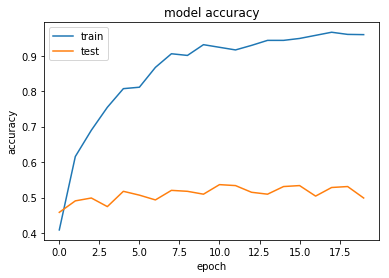

450/450 [==============================] - 9s 21ms/step
[2.65396964708964, 0.48444444444444446]
0.48444444444444446


In [5]:
# Best params for 1D convolutional network

num_epochs = 20

def CNN_1D(nl=2, optimizer='adam', filters=30, lr=0.001, ld=0.0001, dp1=0.3, dp2=0.4, l2=0.005):
    # Naive implementation
    num_layers = nl
    model = Sequential()
    model.add(Permute((2, 1), input_shape=(22,1000)))
    for _ in np.arange(num_layers):
        model.add(Conv1D(filters = filters, kernel_size = 10, activation = 'elu'))
        model.add(BatchNormalization())
        model.add(Dropout(dp1))

    # Remove average pooling layers
#     model.add(AveragePooling1D(pool_size=(75), strides=(15)))
#     model.add(Dropout(dp2))
    
    # GRU Layers inserted right before dense layers
    model.add(GRU(32, return_sequences=True))
    model.add(GRU(32, return_sequences=True))
    model.add(GRU(32, return_sequences=True))
    model.add(GRU(32, return_sequences=True))
    
    model.add(Flatten())
    model.add(Dense(units=4, kernel_initializer='glorot_normal', activity_regularizer=regularizers.l2(l2), kernel_regularizer=regularizers.l2(l2), activation = 'softmax'))

    optimizer = Adam(lr=lr, decay=ld)
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

m = CNN_1D()
avg_acc = 0
for train_idx, test_idx in tt_splits:
    X_train = X[train_idx]
    y_train = y_cat[train_idx]
    X_test = X[test_idx]
    y_test = y_cat[test_idx]
    
    model = m
    
    history = model.fit(X_train, y_train, validation_split=val_split, epochs=num_epochs, batch_size=batch_size)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    metrics = model.evaluate(X_test, y_test, batch_size=batch_size)
    avg_acc += metrics[1]
    print(metrics)
    break

print(avg_acc)